Kotug Project, Group 1

Allan Guzman, June Chen, Sarah Blanc

Let's maybe first remember here the research questions of this project:

**Main Research Question**:

"How can the reliability and efficiency of Kotug OptiPort's tugboat scheduling tool be enhanced through the development and evaluation of novel methods for predicting pickup and drop-off coordinates and other relevant variables?"

**Subresearch Questions**:

- "What advanced predictive methods can be developed and implemented to accurately forecast the coordinates (latitude and longitude) for pickup and drop-off locations of tugs on vessels in the port of Rotterdam?"
- "Which variables, including AIS data, customer requirements, and port-specific constraints (or lack thereof), play a significant role in determining the pickup and drop-off locations and timing of tugs, as well as the required number of tugs for each vessel operation in the port of Rotterdam, and why are they important?"
- "Which of the above mentioned variables can be combined in order to increase the reliability of the results, and why can they be combined?"

The work on this first research question in done in this file, while the 2 other subquestions are answered in the file called "Data_preparation". Finally, this file also contains the conclusion of this project (see end of the file).


**Predictions**

In this notebook, the primary objective is to predict the pick-up and drop-off locations of vessels. Given the variation in data availability across different harbors, a strategic approach was adopted. We specifically target a single harbor for analysis. The flexibility of our model allows us to select any harbor for analysis simply by modifying a designated variable in the code.

To elaborate, we begin by choosing a harbor with substantial data volume. All relevant data pertaining to incoming and departing vessels from this selected harbor is extracted. Our model is then applied to this subset of data. Notably, the ability to change the harbor variable in the code grants the flexibility to extend this analysis to other harbors seamlessly.

Additionally, it is crucial to handle incoming and departing vessels separately in our analysis. Within the chosen harbor's dataset, we further categorize the data. Leaving vessels form one subset, while incoming vessels constitute another. This approach is grounded in the inherent knowledge possessed by vessels and drivers. Specifically, vessels are inherently aware of their status as incoming or departing, and they are assigned to specific ports. These foundational assumptions underpin our analytical framework, ensuring a focused and accurate prediction methodology.

Literature review that explains the path followed through the different methods used:

As part of our effort to answer the first research question and to identify appropriate techniques for geospatial data processing, we painstakingly carried out a literature research. There were two goals in mind: finding viable approaches and understanding how they may be used in the field. Our investigation produced important findings that shaped our methodology. The key findings were the following:
1. Integrated prediction over isolated coordinates: We could have been tempted at first to use several regression models to predict latitude and longitude independently. The literature, however, strongly advises against this practise. Researchers and academics often advise against this segmentation. This advice is supported by the fact that latitude and longitude have complex interactions that are difficult to fully comprehend when viewed as separate concepts. As a result, we began to concentrate on holistic approaches that take into account all of these factors at once.
2. The potential of decision tree classifiers on our discretized polygon of water: Among the methods for classifying our data that showed promise was the decision tree classifier, especially when it came to pick-up and drop-off location prediction. It is not without restrictions, despite its potential. Indeed, we could use it, however we should create a dependence between squares (notable squares that are close to each other as an example). This could be done via new variables that we do not have. Developping them would be too complicated to apply in this project. Furthermore, its failure to adequately incorporate the geospatial nuances of our scenario is a major limitation. This insight drove us to read more in the literature and look for techniques that include the geographical dimension from the beginning. However, you can still see the results from this first method below.  
3.  Introducing kriging, a spatial regression method: Our research introduced us to the Kriging technique, which is a very relevant method for our needs regarding the classification of geospatial data. This could be done on our discretized polygon of water. Furthermore, it is a reliable framework for position prediction that takes into consideration the underlying spatial patterns. Using the spatial correlations found in our data, this approach solves our categorization problem in a way that is contextually rich and nuanced. Unfortunately, after reading a lot about it, we again remarked that this method asks for a lot of complicated work before applying the method. We do not have the knowledges now to handle it in a way that allows us to produce convincing results. Thus, we decided to search for further possible methods.
4. We reached the consensus that it's essential to reconsider approaches that don't rely on our discretized polygon. This broader perspective ensures we're not confined by our initial decision to go for this polygon. Following a brainstorming session and further reading of papers, we determined that ...... TO BE COMPLETED


Import of the librairies

In [2]:
import pandas as pd
import geopandas as gpd
import numpy as np
import json
import matplotlib.pyplot as plt
import re
import seaborn as sn

import folium
import rasterio
import rasterio.mask

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from geopy.distance import geodesic
import folium

from shapely.geometry import Point, Polygon, LineString
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

Import of the data

In [3]:
incoming_weather_size_draught = gpd.read_file('Data/Input_ML/incoming_weather_size_draught.geojson')
incoming_weather_size = gpd.read_file('Data/Input_ML/incoming_weather_size.geojson')
incoming_weather = gpd.read_file('Data/Input_ML/incoming_weather.geojson')

In [4]:
# Assuming 'column_name' is the name of the column containing strings in your DataFrame
label_encoder = LabelEncoder()
incoming_weather_size_draught['Wind_Direction'] = label_encoder.fit_transform(incoming_weather_size_draught['Wind_Direction_Cat2'])
incoming_weather_size_draught['Type_Cat'] = label_encoder.fit_transform(incoming_weather_size_draught['Type'])
incoming_weather_size_draught['Type'] = label_encoder.fit_transform(incoming_weather_size_draught['Type'])
#incoming_weather_size_draught['Wind_speed'] = label_encoder.fit_transform(incoming_weather_size_draught['Wind_speed'])
#incoming_weather_size_draught['to_haven'] = label_encoder.fit_transform(incoming_weather_size_draught['to_haven'])
incoming_weather_size_draught

,area_ID,center,from,from_rounded,to_haven,trip_ID,vessel_mmsi,area,Wind_Direction_Cat1,Wind_Direction_Cat2,Wind_Speed,Lenght,Width,Type,Navigation_draught,geometry,Wind_Direction,Type_Cat
0,1584,POINT (4.14418460267196 51.96555611267634),2022-05-31 23:34:58+00:00,2022-06-01 00:00:00+00:00,3PET,4,538005865,"POLYGON ((4.141337398344955 51.96305993744309,...",SE,S,30,159.0,27.0,2,8.3,POINT (4.14163 51.96557),2,2
1,2573,POINT (4.303422040818238 51.895740300994454),2022-09-08 07:01:29+00:00,2022-09-08 07:00:00+00:00,1PET,6054,538005865,POLYGON ((4.306675663908258 51.893109132781674...,S,S,60,159.0,27.0,2,9.6,POINT (4.30278 51.89511),2,2
2,1820,POINT (4.182629270525371 51.94040644412748),2022-09-11 04:34:51+00:00,2022-09-11 05:00:00+00:00,CKBRUG,6258,538005865,MULTIPOLYGON (((4.185851546765845 51.937623281...,E,E,20,159.0,27.0,2,9.0,POINT (4.17956 51.93872),0,2
3,2335,POINT (4.2649075344304945 51.90749906115679),2022-11-24 02:30:45+00:00,2022-11-24 03:00:00+00:00,3PET,11529,538005865,"POLYGON ((4.268520679547496 51.90582746090193,...",SW,S,100,159.0,27.0,2,7.6,POINT (4.26256 51.90621),2,2
4,2453,POINT (4.284735186045075 51.89810584295876),2022-10-10 08:13:47+00:00,2022-10-10 08:00:00+00:00,TORONT,8267,538005077,MULTIPOLYGON (((4.284689496769295 51.893109132...,S,S,60,158.0,27.0,2,10.3,POINT (4.28256 51.89866),2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4042,1661,POINT (4.158229272691092 51.94804575336068),2022-12-25 00:56:07+00:00,2022-12-25 01:00:00+00:00,7PET,13637,538003962,POLYGON ((4.154055726465209 51.950341609322834...,S,S,60,183.0,32.0,2,11.3,POINT (4.15802 51.95009),2,2
4043,1027,POINT (4.05548868353324 51.98531701165355),2022-12-25 08:17:19+00:00,2022-12-25 08:00:00+00:00,SCHEUR,13651,477345300,"POLYGON ((4.052309101503177 51.98849659368361,...",S,S,50,225.0,32.0,0,14.0,POINT (4.05757 51.98543),2,0
4044,1265,POINT (4.093582835562203 51.97266975312478),2022-12-25 10:19:15+00:00,2022-12-25 10:00:00+00:00,5PET,13655,538008798,"POLYGON ((4.090464085863939 51.96941910150322,...",S,S,60,245.0,42.0,2,15.3,POINT (4.09324 51.97466),2,2
4045,2573,POINT (4.303422040818238 51.895740300994454),2022-12-25 12:25:08+00:00,2022-12-25 12:00:00+00:00,2PET,13660,403579000,POLYGON ((4.306675663908258 51.893109132781674...,S,S,50,183.0,32.0,2,11.4,POINT (4.30134 51.89561),2,2


In [5]:
leaving_weather_size_draught = gpd.read_file('Data/Input_ML/leaving_weather_size_draught.geojson')
leaving_weather_size = gpd.read_file('Data/Input_ML/leaving_weather_size.geojson')
leaving_weather = gpd.read_file('Data/Input_ML/leaving_weather.geojson')

In [6]:
leaving_weather_size_draught


,area_ID,center,to,to_rounded,from_haven,trip_ID,vessel_mmsi,area,Wind_Direction_Cat1,Wind_Direction_Cat2,Wind_Speed,Lenght,Width,Type,Navigation_draught,geometry
0,1224,POINT (4.087284503833875 51.966239519473156),2022-06-01T00:30:17+00:00,2022-06-01 01:00:00+00:00,AMAZ,1,355271000,"POLYGON ((4.084104921803812 51.96941910150322,...",SW,S,30,336.0,46.0,cargo,11.3,POINT (4.08905 51.96774)
1,1224,POINT (4.087284503833875 51.966239519473156),2022-12-06T19:47:53+00:00,2022-12-06 20:00:00+00:00,AMAZ,12473,355271000,"POLYGON ((4.084104921803812 51.96941910150322,...",N,N,70,336.0,46.0,cargo,12.2,POINT (4.08844 51.96875)
2,2893,POINT (4.3541802773739935 51.89784648701013),2022-06-01T01:46:24+00:00,2022-06-01 02:00:00+00:00,WAAL,6,564002000,"POLYGON ((4.351189812329148 51.8994682968418, ...",W,W,70,174.0,27.0,tanker,6.9,POINT (4.35410 51.89852)
3,1224,POINT (4.087284503833875 51.966239519473156),2022-06-01T01:56:33+00:00,2022-06-01 02:00:00+00:00,AMAZ,5,636092784,"POLYGON ((4.084104921803812 51.96941910150322,...",W,W,70,300.0,46.0,cargo,10.9,POINT (4.08988 51.96918)
4,1186,POINT (4.0808868772623645 51.97886976519478),2022-07-08T13:28:19+00:00,2022-07-08 13:00:00+00:00,AMAZ,2398,636092784,"POLYGON ((4.084104921803812 51.97577826556335,...",W,W,70,300.0,46.0,cargo,11.0,POINT (4.08271 51.97634)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3591,1107,POINT (4.068207011653495 51.98531701165355),2022-12-24T20:43:20+00:00,2022-12-24 21:00:00+00:00,LNG,13624,636021030,"POLYGON ((4.065027429623431 51.98849659368361,...",S,S,60,294.0,45.0,tanker,9.6,POINT (4.06556 51.98376)
3592,1424,POINT (4.11923161276585 51.96652963319716),2022-12-25T02:58:17+00:00,2022-12-25 03:00:00+00:00,CKVTTI,13638,636015170,"POLYGON ((4.115900742104447 51.96941910150322,...",S,S,60,230.0,38.0,cargo,7.8,POINT (4.12067 51.96743)
3593,1345,POINT (4.106342470416202 51.97244671050565),2022-12-25T09:54:02+00:00,2022-12-25 10:00:00+00:00,SCHEUR,13650,636014481,MULTIPOLYGON (((4.10954157804432 51.9694191015...,S,S,60,292.0,45.0,cargo,17.6,POINT (4.10327 51.97232)
3594,2493,POINT (4.290930864333445 51.897467449818606),2022-12-25T10:35:05+00:00,2022-12-25 11:00:00+00:00,3PET,13653,538009704,"POLYGON ((4.287598171727877 51.8994682968418, ...",S,S,50,140.0,21.0,tanker,6.5,POINT (4.29352 51.89772)


Encoding of the data that are not numerical

In [7]:
# Assuming 'column_name' is the name of the column containing strings in your DataFrame
label_encoder = LabelEncoder()
leaving_weather_size_draught['Wind_Direction'] = label_encoder.fit_transform(leaving_weather_size_draught['Wind_Direction_Cat2'])
leaving_weather_size_draught['Wind_Speed'] = label_encoder.fit_transform(leaving_weather_size_draught['Wind_Speed'])
leaving_weather_size_draught['Type'] = label_encoder.fit_transform(leaving_weather_size_draught['Type'])
#leaving_weather_size_draught['from_haven'] = label_encoder.fit_transform(leaving_weather_size_draught['from_haven'])


Code to know what are the 2 most used harbour for the incoming and leaving vessels

In [8]:
leaving_top = leaving_weather_size_draught['from_haven'].value_counts()
incoming_top = incoming_weather_size_draught['to_haven'].value_counts()
print(leaving_top[0:2])
print(incoming_top[0:2])

from_haven
EURO      451
AMALIA    309
Name: count, dtype: int64
to_haven
EURO    480
7PET    377
Name: count, dtype: int64


Extraction of the data that concerns the most used harbours (one for leaving vessels and one for incoming vessels)

In [9]:
top_leaving = 'EURO'
top_incoming = 'EURO'

harbor_leaving = leaving_weather_size_draught[leaving_weather_size_draught['from_haven']== top_leaving]
harbor_incoming = incoming_weather_size_draught[incoming_weather_size_draught['to_haven']== top_incoming]


In [10]:
columns_leaving = [
    'from_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght',
    'Width',
    'Type',
    'geometry'
]

columns_incoming = [
    'to_haven',
    'Wind_Direction',
    'Wind_Speed',
    'Lenght'	,
    'Width'	,
    'Type',
    'geometry'
]


Check of potential correlations in the data

In [15]:
corr_matrix_incoming = incoming_weather_size_draught[columns_incoming].corr()
sn.heatmap(corr_matrix_incoming, annot=True)
plt.show()

ValueError: could not convert string to float: '3PET'

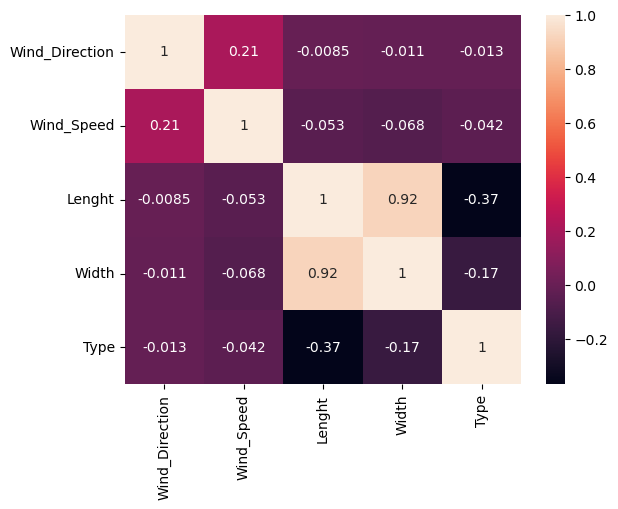

In [ ]:
corr_matrix_leaving = leaving_weather_size_draught[columns_leaving].corr()
sn.heatmap(corr_matrix_leaving, annot=True)
plt.show()

As observed, aside from Length and Width, there are no notably high correlations within the datasets.

**BELOW, YOU CAN SEE THE IMPLEMENTATION OF THE POINT 2 FROM THE LITERATURE REVIEW: THE DECISION TREE ON THE DISCRETIZED POLYGON.**

# Trayectories approach

In [16]:
trayectories = gpd.read_file('Data/Input_ML/trayectories.geojson')
trayectories

,haven,geometry
0,EURO,"LINESTRING (4.05447 51.95948, 4.05974 51.96050..."
1,7PET,"LINESTRING (4.20557 51.91943, 4.20723 51.92091..."
2,AMALIA,"LINESTRING (3.99597 51.95317, 3.99772 51.95762..."
3,AMAZ,"LINESTRING (4.05511 51.94830, 4.06875 51.95011..."
4,CKVTTI,"LINESTRING (4.19062 51.93405, 4.19031 51.93402..."
5,YANG,"LINESTRING (4.02215 51.97412, 4.02456 51.97378..."
6,WAAL,"LINESTRING (4.44292 51.88902, 4.44384 51.88766..."
7,3PET,"LINESTRING (4.30303 51.87880, 4.30635 51.88395..."
8,MISS,"LINESTRING (4.05297 51.93708, 4.06652 51.94105..."
9,PET8,"LINESTRING (4.07171 51.96815, 4.07190 51.96624..."


In [17]:
selected_haven = 'AMALIA'

incoming_prediction_input = incoming_weather_size_draught[columns_incoming]
incoming_prediction_input_am = incoming_prediction_input[incoming_prediction_input['to_haven'] == selected_haven]

In [18]:
incoming_prediction_input_am

,to_haven,Wind_Direction,Wind_Speed,Lenght,Width,Type,geometry
18,AMALIA,3,50,400.0,59.0,0,POINT (4.07186 51.98155)
20,AMALIA,0,60,400.0,59.0,0,POINT (4.05912 51.98528)
35,AMALIA,3,40,143.0,22.0,0,POINT (3.99852 51.96609)
64,AMALIA,1,30,189.0,30.0,0,POINT (4.07889 51.97777)
65,AMALIA,1,50,189.0,30.0,0,POINT (4.06139 51.98362)
...,...,...,...,...,...,...,...
3820,AMALIA,0,60,190.0,30.0,0,POINT (4.05252 51.96826)
3852,AMALIA,1,80,334.0,43.0,0,POINT (4.08768 51.97538)
3933,AMALIA,2,20,400.0,62.0,0,POINT (4.08708 51.97040)
3947,AMALIA,3,40,300.0,40.0,0,POINT (4.06771 51.98220)


In [21]:
#def closest_point(trayectories_gdf, trips, haven = selected_haven):

trips = incoming_prediction_input[incoming_prediction_input['to_haven'] == selected_haven]
line = trayectories[trayectories['haven'] == selected_haven]['geometry'].iloc[0]

def find_nearest_point(row):
    point = Point(row['geometry'])
    nearest_point = line.interpolate(line.project(point))
    return nearest_point

trips['nearest'] = trips.apply(find_nearest_point, axis=1)

trips.set_geometry('nearest', crs = trips.crs, inplace=True)
#return trips

# amalia_np = closest_point(trayectories, incoming_prediction_input)


/Users/allanguzmanf/opt/anaconda3/envs/CIEM6302/lib/python3.10/site-packages/geopandas/geodataframe.py:1538: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [24]:
print(line)

LINESTRING (3.995974115983027 51.95316916548798, 3.997722286252062 51.95761503197195, 3.997775086218017 51.95775171013662, 3.997826896295494 51.95788827057415, 3.997877716484493 51.958024713284544, 3.997927546785015 51.95816103826779, 3.997976387197059 51.9582972455239, 3.998024237720626 51.95843333505287, 3.998071098355715 51.958569306854685, 3.998116969102327 51.95870516092936, 3.998161849960461 51.9588408972769, 3.998205740930117 51.958976515897305, 3.998248642011296 51.95911201679056, 3.998290553203998 51.95924739995667, 3.998331474508222 51.95938266539565, 3.998371405923968 51.95951781310748, 3.998410347451237 51.95965284309218, 3.998448299090029 51.95978775534973, 3.998485260840342 51.95992254988013, 3.998521232702179 51.960057226683396, 3.998556214675538 51.96019178575953, 3.998590206760419 51.96032622710851, 3.998623208956823 51.96046055073034, 3.998655221264749 51.96059475662505, 3.998686243684197 51.960728844792605, 3.998716276215168 51.960862815233014, 3.998745318857662 51.9

In [70]:
poly_map = folium.Map(
    location=[51.9, 4.2],    
    zoom_start=11
)

folium.features.GeoJson(trips['nearest']).add_to(poly_map) 

poly_map




In [32]:
from shapely.geometry import LineString, Point

# Create a LineString representing the path
path = LineString([(0, 0), (4, 0), (4, 2), (0, 2)])  # Replace with your path coordinates

# Create two points for which you want to calculate the distance
point1 = Point(1, 1)  # Replace with the coordinates of your first point
point2 = Point(3, 1)  # Replace with the coordinates of your second point

points = [point1, point2]

# Calculate the distance along the path
distance_along_path = path.project(point2) - path.project(point1)

distance_along_path



In [35]:
from bokeh.plotting import figure, show

p = figure(title="interactive plot example", x_axis_label='x', y_axis_label='y')

x, y = path.coords.xy
p.line(x, y, legend_label="lines", color="blue", line_width=2)
    

for point in points:
    
    p.circle(point.x, point.y, legend_label="points", size=5, color="red", alpha=0.5)
    

show(p)

**Prediction for LEAVING**

In [12]:
X = harbor_leaving[columns_leaving]
y = harbor_leaving['area_ID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)
#X_from_lat_train, X_from_lat_test, y_from_lat_train, y_from_lat_test = train_test_split(leaving_weather_size_draught[columns_leaving], leaving_weather_size_draught['area_ID'], test_size=0.3, random_state=42)
data = X_test

In [13]:
print("Number of features in training data:", X_train.shape[1]) 
print("Number of features in test data:", X_test.shape[1])

Number of features in training data: 5
Number of features in test data: 5


Decision Tree Classifier

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.datasets import load_iris


# Initialize the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=3)

# Train the classifier using the training data
x = decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = decision_tree_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

print("Accuracy of the Decision Tree Classifier: {:.2f}%".format(accuracy * 100))

# Add predictions to the original DataFrame

data['Predicted_Area_ID'] = predictions




Accuracy of the Decision Tree Classifier: 13.72%


,Direction,Wind_speed,Lenght,Width,Type,Predicted_Area_ID
1247,7,3,228.0,37.0,0,1146
596,8,3,275.0,40.0,0,1225
1406,5,2,300.0,48.0,0,1224
1003,8,3,300.0,43.0,0,1224
2993,0,3,330.0,48.0,0,1225
...,...,...,...,...,...,...
1011,5,2,283.0,40.0,0,1146
2461,0,3,151.0,22.0,0,1104
297,3,3,294.0,32.0,0,987
2196,6,3,184.0,25.0,0,1224


In [15]:
merged_df = pd.merge(data, leaving_weather_size_draught, left_index=True, right_index=True, how='left')
#merged_df

In [16]:
# Create a new empty list to store prediction_center values
prediction_centers = []

# Iterate through the rows of merged_df
for index, row in merged_df.iterrows():
    # Get the Predicted_Area_ID value from the current row of merged_df
    predicted_area_id = row['Predicted_Area_ID']
    
    # Find the corresponding row in incoming_weather_size_draught where area_ID matches Predicted_Area_ID
    matching_row = leaving_weather_size_draught[leaving_weather_size_draught['area_ID'] == predicted_area_id]
    
    # Check if a matching row is found
    if not matching_row.empty:
        # Get the value from the 'center' column in the matching row
        prediction_center = matching_row['center'].values[0]
    else:
        # If no matching row is found, assign a default value (you can change this as per your requirement)
        prediction_center = None
    
    # Append the prediction_center value to the list
    prediction_centers.append(prediction_center)

# Add the prediction_centers list as a new column to merged_df
merged_df['prediction_center'] = prediction_centers

#merged_df

In [17]:
# Function to convert string representation of coordinates to actual coordinates
def parse_coordinates(coord_str):
    if coord_str:
        # Extract numerical values from the string (format: 'POINT (longitude latitude)')
        coordinates = re.findall(r"[-+]?\d*\.\d+|\d+", coord_str)
        lat, lon = map(float, coordinates)
        return lat, lon
    else:
        return None

# Convert 'from_location' and 'center' columns to actual coordinates
merged_df['to_location_coords'] = merged_df['to_location'].apply(parse_coordinates)
merged_df['center_coords'] = merged_df['prediction_center'].apply(parse_coordinates)

# Function to calculate distance between two points using geodesic
def calculate_distance(row):
    if row['to_location_coords'] and row['center_coords']:
        return geodesic(row['to_location_coords'], row['center_coords']).meters
    else:
        return None

# Apply the calculate_distance function to the DataFrame to compute distances
merged_df['distance_to_predicted_center'] = merged_df.apply(calculate_distance, axis=1)
moyenne_distance = merged_df['distance_to_predicted_center'].mean()

# Afficher la moyenne
print("Average distance between predicted and real locations: ", moyenne_distance, "meters")



Average distance between predicted and real locations:  1651.1098602209843 meters


**Predictions for INCOMING**

In [18]:
X = harbor_incoming[columns_incoming]
y = harbor_incoming['area_ID']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=3)
#X_from_lat_train, X_from_lat_test, y_from_lat_train, y_from_lat_test = train_test_split(leaving_weather_size_draught[columns_leaving], leaving_weather_size_draught['area_ID'], test_size=0.3, random_state=42)
data = X_test

In [19]:
print("Number of features in training data:", X_train.shape[1])
print("Number of features in test data:", X_test.shape[1])

Number of features in training data: 5
Number of features in test data: 5


In [20]:

# Initialize the Decision Tree Classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=3)

# Train the classifier using the training data
x = decision_tree_classifier.fit(X_train, y_train)

# Make predictions on the test data
predictions = decision_tree_classifier.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, predictions)

print("Accuracy of the Decision Tree Classifier: {:.2f}%".format(accuracy * 100))

# Add predictions to the original DataFrame

data['Predicted_Area_ID'] = predictions


Accuracy of the Decision Tree Classifier: 12.92%


,Direction,Wind_speed,Lenght,Width,Type,Predicted_Area_ID
219,2,1,299.0,49.0,0,1224
772,5,3,300.0,40.0,0,1027
600,8,0,243.0,32.0,0,1103
2258,7,1,366.0,48.0,0,1067
2033,5,0,333.0,48.0,0,1107
...,...,...,...,...,...,...
407,7,1,270.0,40.0,0,1106
1780,5,3,300.0,40.0,0,1027
1224,5,3,300.0,43.0,0,1106
3032,6,1,300.0,48.0,0,1186


In [21]:
merged_df = pd.merge(data, incoming_weather_size_draught, left_index=True, right_index=True, how='left')
#merged_df

In [22]:
# Create a new empty list to store prediction_center values
prediction_centers = []

# Iterate through the rows of merged_df
for index, row in merged_df.iterrows():
    # Get the Predicted_Area_ID value from the current row of merged_df
    predicted_area_id = row['Predicted_Area_ID']
    
    # Find the corresponding row in incoming_weather_size_draught where area_ID matches Predicted_Area_ID
    matching_row = incoming_weather_size_draught[incoming_weather_size_draught['area_ID'] == predicted_area_id]
    
    # Check if a matching row is found
    if not matching_row.empty:
        # Get the value from the 'center' column in the matching row
        prediction_center = matching_row['center'].values[0]
    else:
        # If no matching row is found, assign a default value (you can change this as per your requirement)
        prediction_center = None
    
    # Append the prediction_center value to the list
    prediction_centers.append(prediction_center)

# Add the prediction_centers list as a new column to merged_df
merged_df['prediction_center'] = prediction_centers

#merged_df

In [24]:
# Function to convert string representation of coordinates to actual coordinates
def parse_coordinates(coord_str):
    if coord_str:
        # Extract numerical values from the string (format: 'POINT (longitude latitude)')
        coordinates = re.findall(r"[-+]?\d*\.\d+|\d+", coord_str)
        lat, lon = map(float, coordinates)
        return lat, lon
    else:
        return None

# Convert 'to_location' and 'center' columns to actual coordinates
merged_df['from_location_coords'] = merged_df['from_location'].apply(parse_coordinates)
merged_df['center_coords'] = merged_df['prediction_center'].apply(parse_coordinates)

# Function to calculate distance between two points using geodesic
def calculate_distance(row):
    if row['from_location_coords'] and row['center_coords']:
        return geodesic(row['from_location_coords'], row['center_coords']).meters
    else:
        return None

# Apply the calculate_distance function to the DataFrame to compute distances
merged_df['distance_to_predicted_center'] = merged_df.apply(calculate_distance, axis=1)
moyenne_distance = merged_df['distance_to_predicted_center'].mean()

# Afficher la moyenne
print("Average distance between predicted and real locations: ", moyenne_distance, "meters")


Average distance between predicted and real locations:  1418.1801243934678 meters


**BELOW, YOU CAN SEE THE IMPLEMENTATION OF THE POINT 4 FROM THE LITERATURE REVIEW: ... TO BE COMPLETED.**

**CONCLUSION**

...